In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Check total of NaN values in each column
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
# Check feature cardinality
df.nunique(dropna=True)

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [6]:
# Check datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Preprocessing
- remove rows with numerous NaN values in TRAINING 
- convert cryo, vip into yes/no
- split cabin into [3] new columns [deck, num, side]
- remove name, passengerid, cabin
- check unique values in categorical columns
- onehot categorical columns
- scale dataset
- split training/test

In [108]:
def imputer(dataframe, columns, is_object):
    # Fill in NaN values with the mean of each feature
    for feature in columns:
        if type(feature) == list:
            continue
        if not is_object:
            # If feature is numeric, fill NaN values with median of feature
            value = dataframe[feature].median()
            dataframe[feature] = dataframe[feature].fillna(value)
        else:
            # If feature is categorical, fill NaN values with most frequent value in feature
            value = dataframe[feature].mode()[0]
            dataframe[feature] = dataframe[feature].fillna(value)

    return dataframe


def onehot_encode(dataframe):
    # Creates list of categorical features in dataframe
    columns = dataframe.select_dtypes(include='object').columns
    # Adds prefix to new column title
    prefixes = [x.upper() for x in columns]
    # Creates copy of dataframe to modify
    temp_df = dataframe.copy()
    
    # Loop through each column/prefix and add encoded columns to exisiting dataframe
    for feature, prefix in zip(columns, prefixes):
        encoded = pd.get_dummies(temp_df[feature], prefix=prefix)
        temp_df = pd.concat([temp_df, encoded], axis=1)
    
    # Drop original categorical columns
    temp_df.drop(columns, axis=1, inplace=True)
    return temp_df


def handle_null(dataframe):
    null_features = dataframe.columns[dataframe.isna().any()].tolist()
    for feature in null_features:
        # Create new column containing boolean if value from current feature is NaN
        dataframe[f"NULL_{feature}"] = dataframe[feature].apply(lambda x: True if pd.isnull(x) else False)
    
    return dataframe


def broke_passengers(dataframe):
    temp = dataframe.loc[:, 'RoomService':'VRDeck']
    broke = []
    for index, row in temp.iterrows():
        if row.sum() == 0:
            broke.append(1)
        else:
            broke.append(0)
    
    dataframe['Broke'] = broke
    return dataframe
        
    
def preprocessing_train(dataframe, test):
    # Drop columns with high cardinality
    dataframe.drop(['PassengerId', 'Name', 'VIP'], axis=1, inplace=True)
    
    # Check if passenger is a child
#     X['Child'] = X['Age'].apply(lambda x: 1 if x <= 10 else 0)
#     X['Elder'] = X['Age'].apply(lambda x: 1 if x >= 60 else 0)
    
    # Convert Cabin values into separate features
    dataframe['Cabin'] = dataframe['Cabin'].apply(lambda x: x.split('/') if not pd.isnull(x) and len(x.split('/')) == 3 else np.nan)
    dataframe['Deck'] = dataframe['Cabin'].apply(lambda x: x[0] if type(x) == list and not pd.isnull(x[0]) else np.nan)
    dataframe['Num'] = dataframe['Cabin'].apply(lambda x: int(x[1]) if type(x) == list and not pd.isnull(x[1]) else np.nan)
    dataframe['Side'] = dataframe['Cabin'].apply(lambda x: x[2] if type(x) == list and not pd.isnull(x[2]) else np.nan)
#     X['Cabin'] = X['Cabin'].apply(lambda x: "".join(x) if type(x) == list else np.nan)
    
    # Drop Cabin column
    dataframe.drop(['Cabin', 'Age'], axis=1, inplace=True)
    
    # Detect NaN values in each column
    dataframe = handle_null(dataframe)
    
    # Fill NaN values
    dataframe = imputer(dataframe, dataframe.select_dtypes(include=np.number).columns, False)
    dataframe = imputer(dataframe, dataframe.select_dtypes(include='object').columns, True)
    
    # Identify broke passengers lel
    dataframe = broke_passengers(dataframe)

    # Convert boolean features to 0/1
#     X['CryoSleep'] = X['CryoSleep'].astype(int)
#     X['VIP'] = X['VIP'].astype(int)
    if not test:
        dataframe['Transported'] = X['Transported'].astype(int)
    
    return dataframe

In [109]:
X = df.copy()
print(f"Before preprocessing: {X.shape}")
X = preprocessing_train(X, test=False)
print(f"After preprocessing: {X.shape}")

Before preprocessing: (8693, 14)
After preprocessing: (8693, 24)


In [110]:
X.head()

,HomePlanet,CryoSleep,Destination,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,...,NULL_Destination,NULL_RoomService,NULL_FoodCourt,NULL_ShoppingMall,NULL_Spa,NULL_VRDeck,NULL_Deck,NULL_Num,NULL_Side,Broke
0,Europa,False,TRAPPIST-1e,0.0,0.0,0.0,0.0,0.0,0,B,...,False,False,False,False,False,False,False,False,False,1
1,Earth,False,TRAPPIST-1e,109.0,9.0,25.0,549.0,44.0,1,F,...,False,False,False,False,False,False,False,False,False,0
2,Europa,False,TRAPPIST-1e,43.0,3576.0,0.0,6715.0,49.0,0,A,...,False,False,False,False,False,False,False,False,False,0
3,Europa,False,TRAPPIST-1e,0.0,1283.0,371.0,3329.0,193.0,0,A,...,False,False,False,False,False,False,False,False,False,0
4,Earth,False,TRAPPIST-1e,303.0,70.0,151.0,565.0,2.0,1,F,...,False,False,False,False,False,False,False,False,False,0


In [111]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HomePlanet         8693 non-null   object 
 1   CryoSleep          8693 non-null   bool   
 2   Destination        8693 non-null   object 
 3   RoomService        8693 non-null   float64
 4   FoodCourt          8693 non-null   float64
 5   ShoppingMall       8693 non-null   float64
 6   Spa                8693 non-null   float64
 7   VRDeck             8693 non-null   float64
 8   Transported        8693 non-null   int64  
 9   Deck               8693 non-null   object 
 10  Num                8693 non-null   float64
 11  Side               8693 non-null   object 
 12  NULL_HomePlanet    8693 non-null   bool   
 13  NULL_CryoSleep     8693 non-null   bool   
 14  NULL_Destination   8693 non-null   bool   
 15  NULL_RoomService   8693 non-null   bool   
 16  NULL_FoodCourt     8693 

## EDA
- check correlations between target label and features
- indentify useful features and compare target label in histogram
- check for target label imbalance
- check for outliers in useful features

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Set plot size
plt.rcParams['figure.figsize'] = [15, 6]

In [113]:
s = StandardScaler()
n = X.drop(X.select_dtypes(include=[bool, 'object']).columns, axis=1)

# Standardized numeric dataframe
s_df = pd.DataFrame(s.fit_transform(n), columns=n.columns)

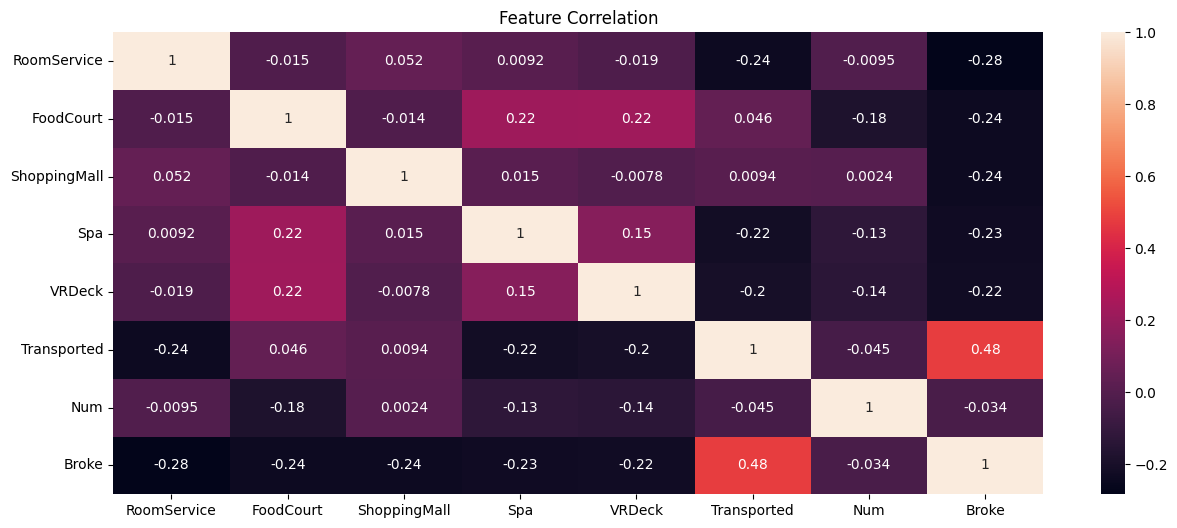

In [114]:
# Feature correlation
plt.title('Feature Correlation')
sns.heatmap(s_df.corr(), annot=True, cmap='rocket')
plt.show()

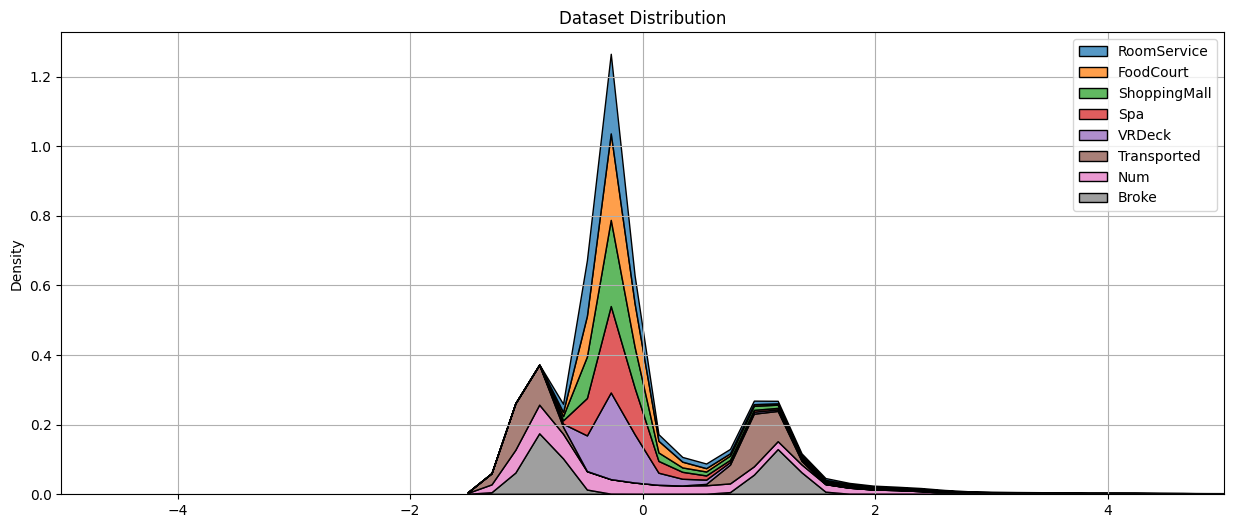

In [115]:
# Distribution
plt.title('Dataset Distribution')
sns.kdeplot(data=s_df, multiple='stack')
plt.xlim([-5, 5])
plt.grid(True)
plt.show()

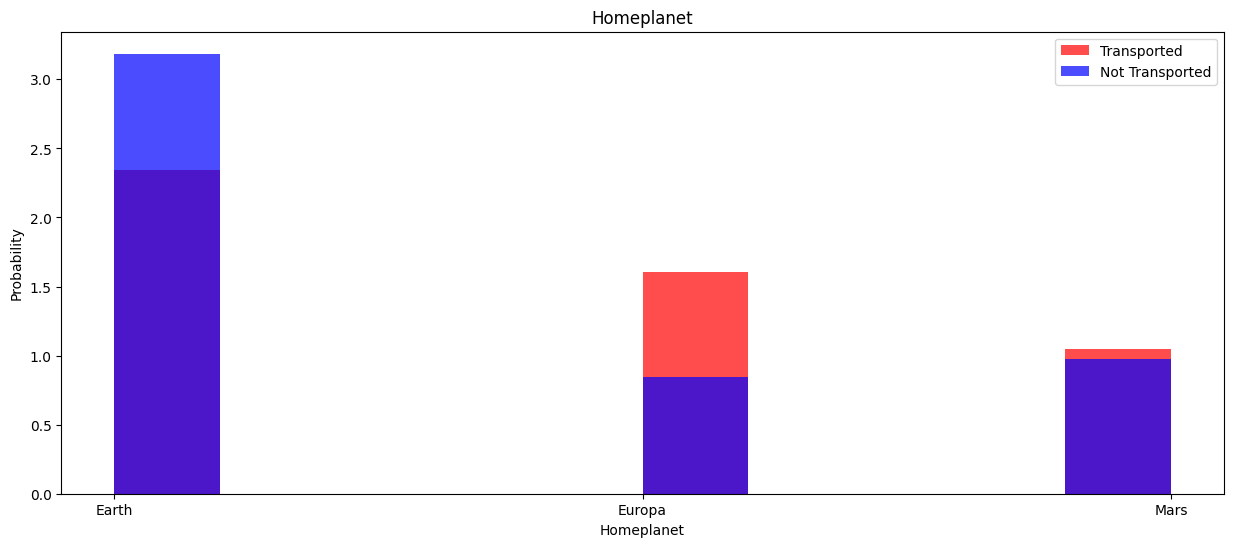

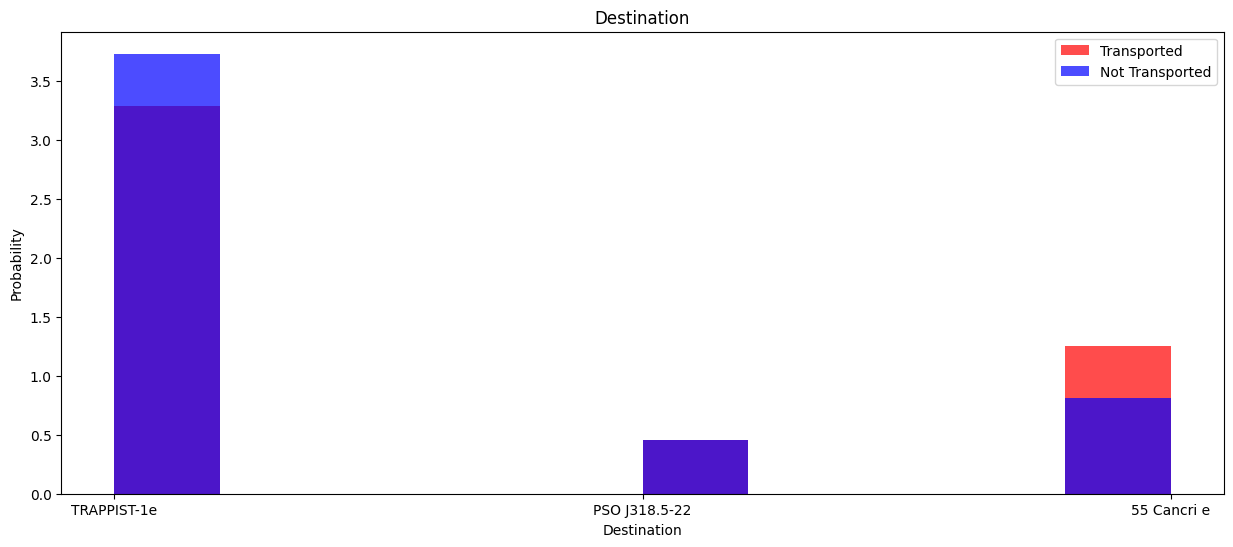

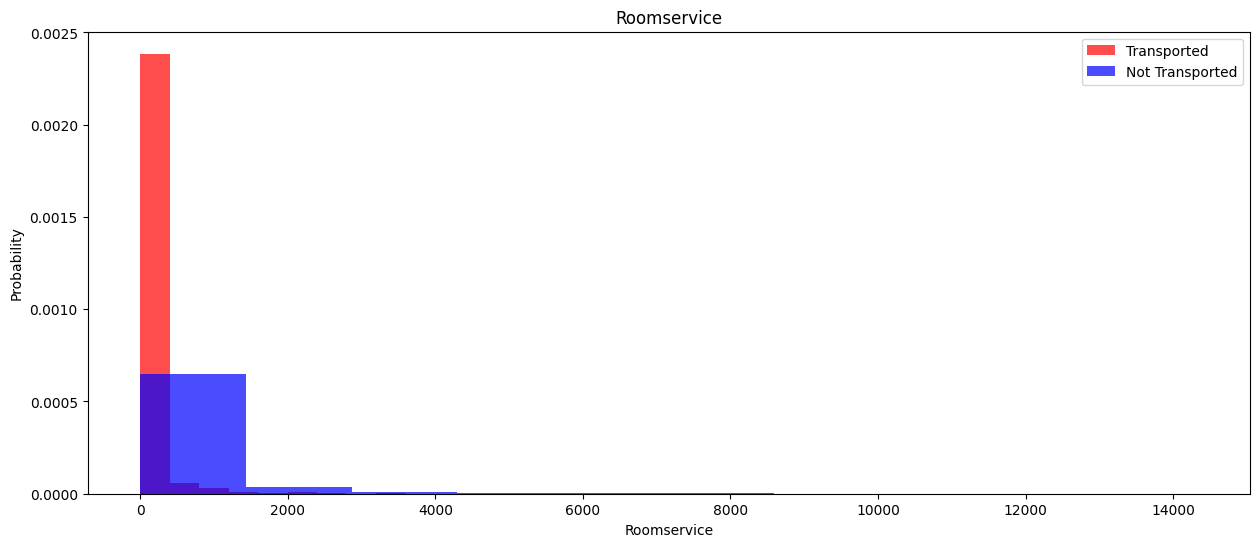

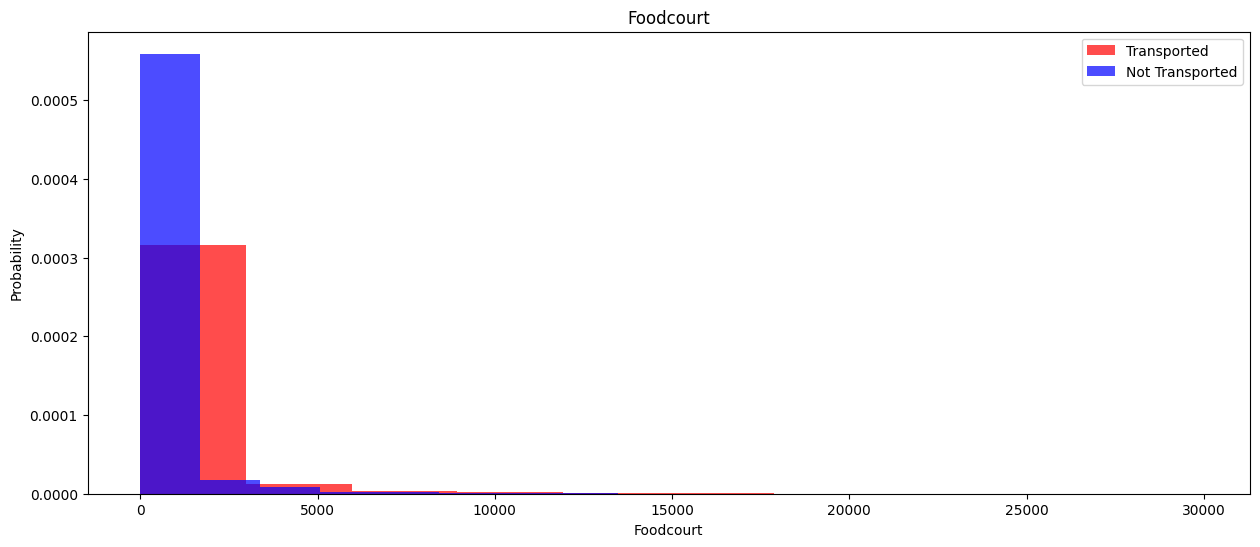

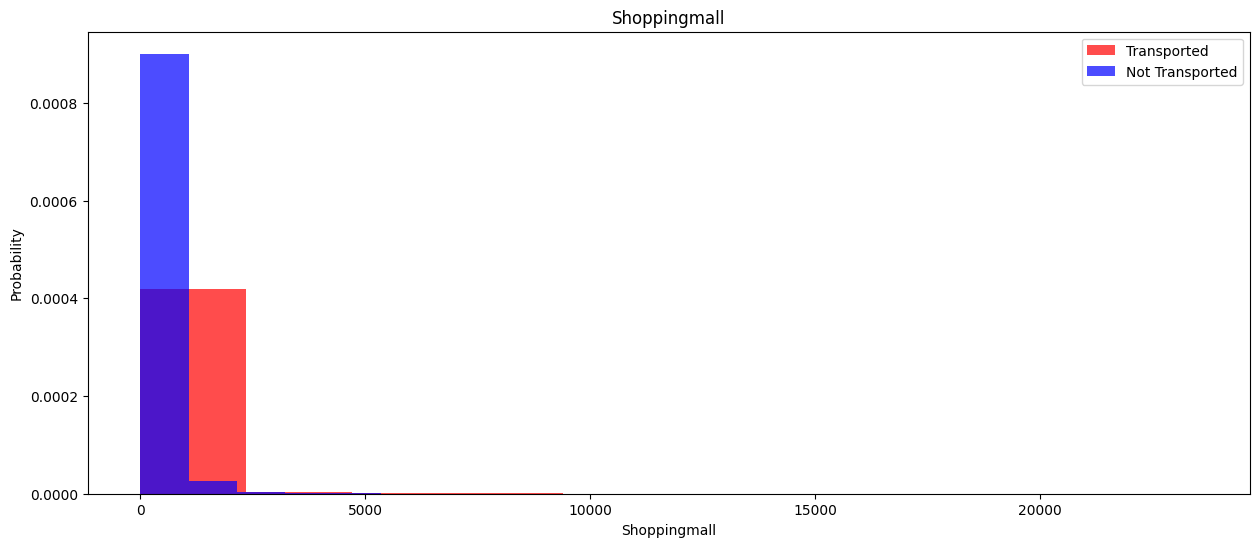

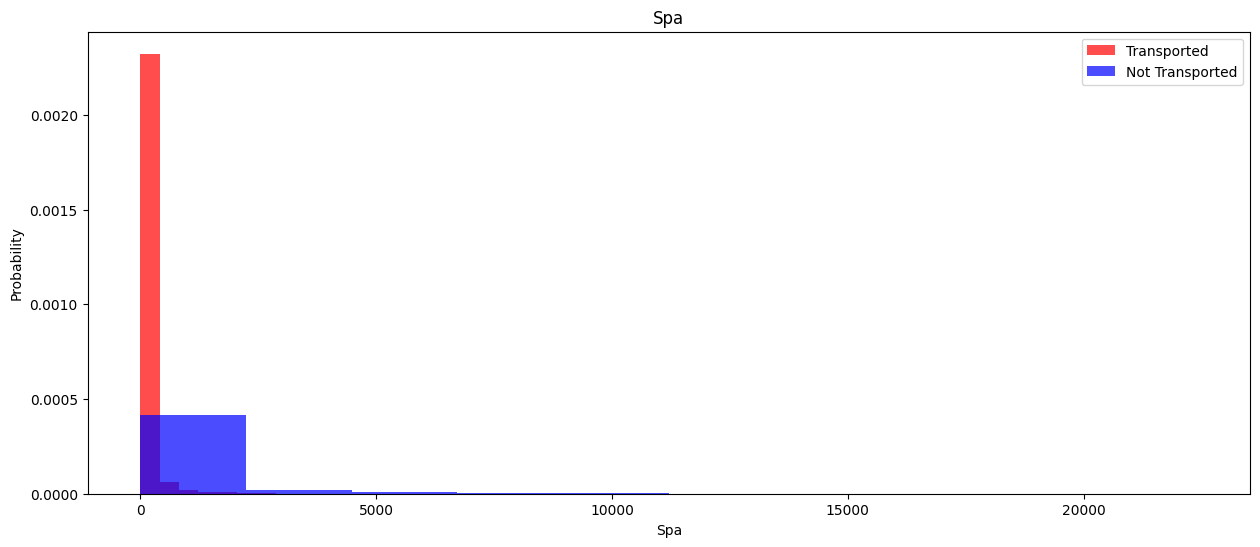

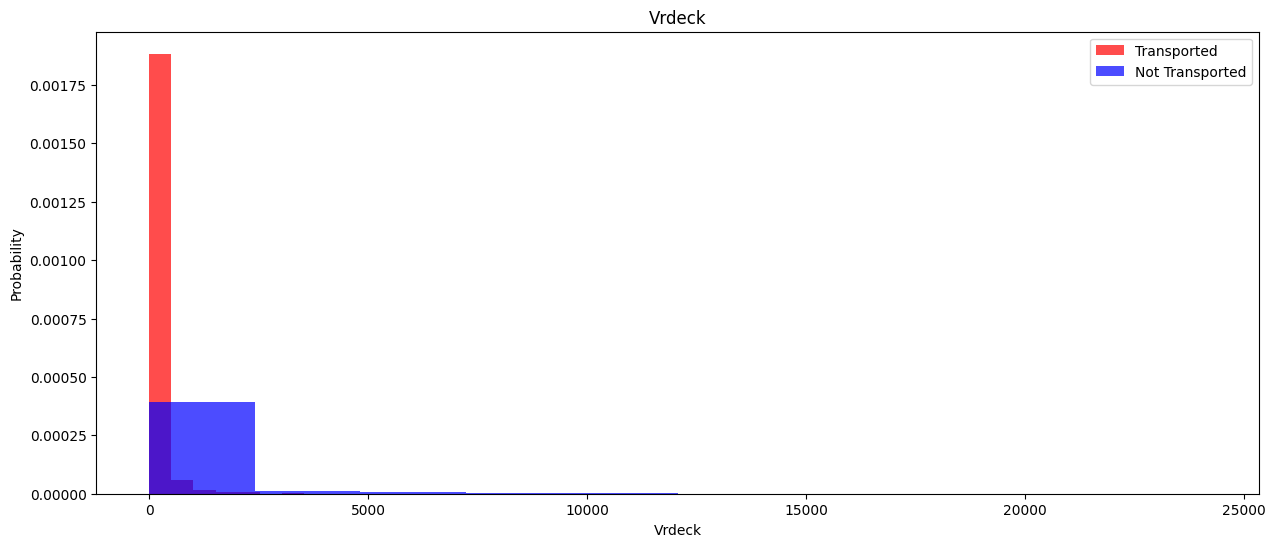

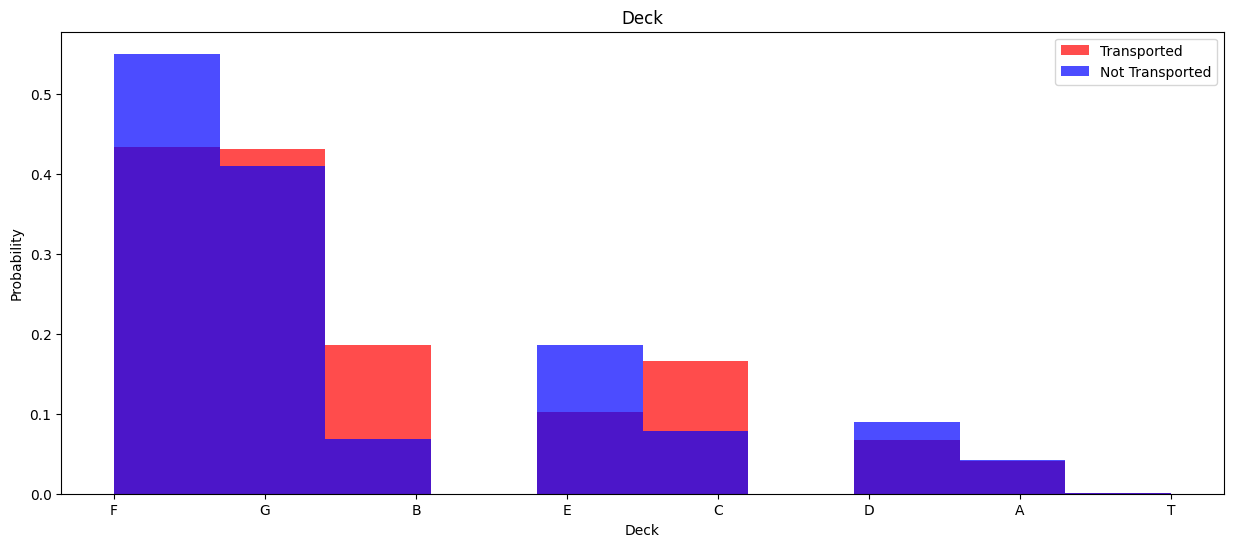

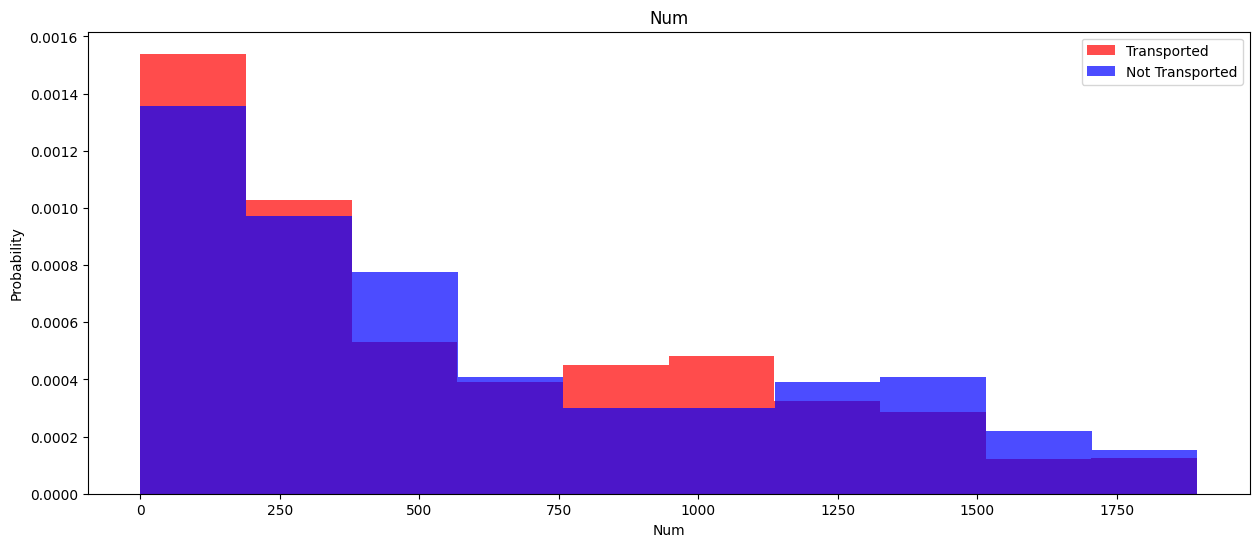

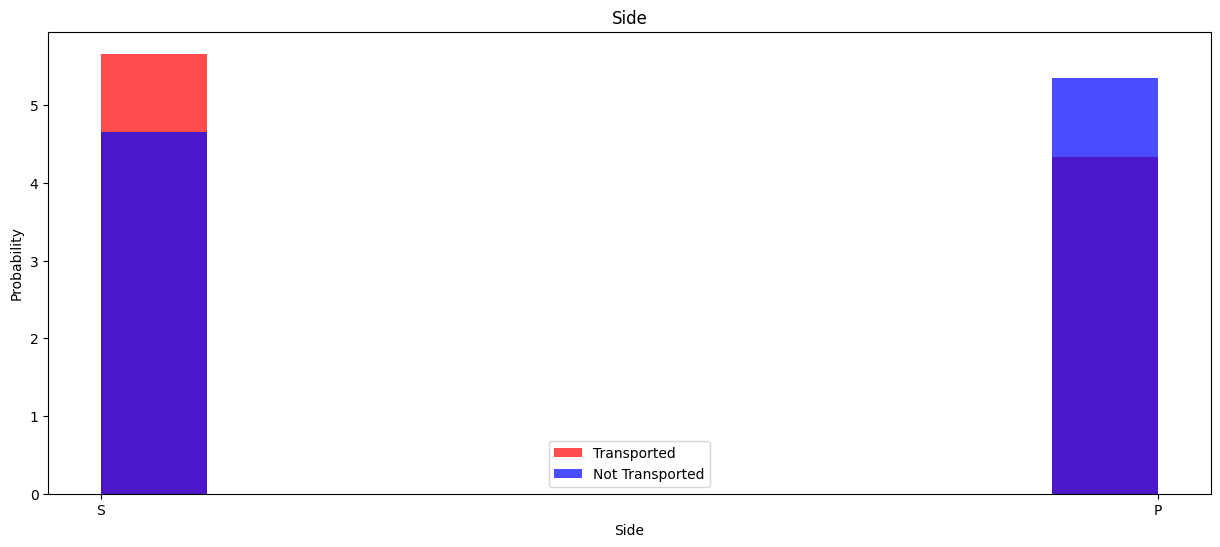

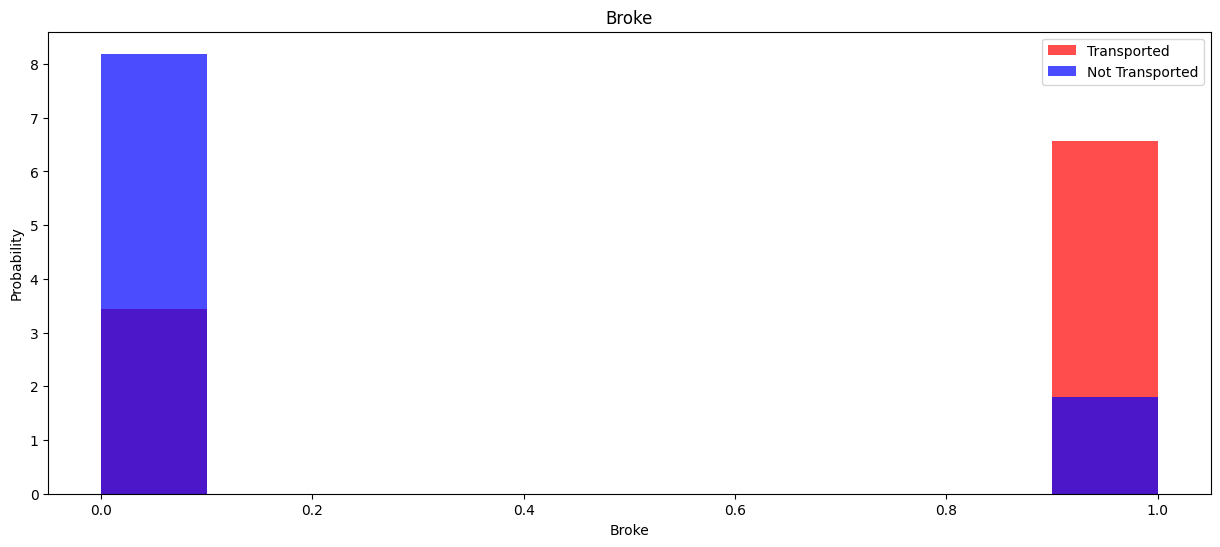

In [116]:
# Histogram plots
t = X[X['Transported'] == 1]
nt = X[X['Transported'] == 0]

for feature in X.select_dtypes(exclude=bool):
    if feature == 'Transported':
        continue
    plt.title(feature.title())
    plt.hist(t[feature], label='Transported', color='r', alpha=0.7, density=True)
    plt.hist(nt[feature], label='Not Transported', color='b', alpha=0.7, density=True)
    plt.xlabel(feature.title())
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

## Model Prep
- instantiate X, y
- split dataset
- scale and fit X_train
- transform X_test
- import models 

In [117]:
from sklearn.model_selection import train_test_split

In [118]:
X, y = X.drop(['Transported'], axis=1), X['Transported']

In [119]:
# Onehot categorical features
X = onehot_encode(X)

In [120]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6954, 35)
y_train shape: (6954,)
X_test shape: (1739, 35)
y_test shape: (1739,)


In [121]:
# Standardize X_train and X_test
X_train = pd.DataFrame(s.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(s.transform(X_test), columns=X_test.columns)

In [122]:
X_train.head(3)

,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,NULL_HomePlanet,NULL_CryoSleep,NULL_Destination,...,DECK_A,DECK_B,DECK_C,DECK_D,DECK_E,DECK_F,DECK_G,DECK_T,SIDE_P,SIDE_S
0,-0.729421,0.657471,-0.278289,-0.281733,-0.273757,-0.258472,-0.407412,-0.156381,-0.16301,-0.144898,...,-0.172965,-0.310644,-0.308692,-0.240089,-0.337472,1.384980,-0.648115,-0.026824,-0.963285,0.963285
1,-0.729421,-0.291015,-0.169343,-0.281733,0.180798,-0.253056,2.064028,-0.156381,-0.16301,-0.144898,...,-0.172965,-0.310644,-0.308692,-0.240089,-0.337472,1.384980,-0.648115,-0.026824,1.038114,-1.038114
2,1.370950,-0.326695,-0.278289,-0.281733,-0.273757,-0.266596,0.127642,-0.156381,-0.16301,-0.144898,...,-0.172965,-0.310644,-0.308692,-0.240089,-0.337472,-0.722032,1.542936,-0.026824,1.038114,-1.038114


In [123]:
X_train.columns

Index(['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Num', 'NULL_HomePlanet', 'NULL_CryoSleep',
       'NULL_Destination', 'NULL_RoomService', 'NULL_FoodCourt',
       'NULL_ShoppingMall', 'NULL_Spa', 'NULL_VRDeck', 'NULL_Deck', 'NULL_Num',
       'NULL_Side', 'Broke', 'HOMEPLANET_Earth', 'HOMEPLANET_Europa',
       'HOMEPLANET_Mars', 'DESTINATION_55 Cancri e',
       'DESTINATION_PSO J318.5-22', 'DESTINATION_TRAPPIST-1e', 'DECK_A',
       'DECK_B', 'DECK_C', 'DECK_D', 'DECK_E', 'DECK_F', 'DECK_G', 'DECK_T',
       'SIDE_P', 'SIDE_S'],
      dtype='object')

In [124]:
# Model selection
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [125]:
xgb = XGBClassifier()
lr = LogisticRegression()
rf = RandomForestClassifier()
gbc = GradientBoostingClassifier()

models = {'XGB': xgb, 'LogisticReg': lr, 'RandomForest': rf, 'GradientBoost': gbc}

## Model Testing

In [126]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error, 
    log_loss,
    precision_score, 
    recall_score, 
    roc_auc_score, 
    accuracy_score
)

In [127]:
# Utility functions

def metric_testing(model, y_true, y_hat, test, title):
    """
    Calculates numerous metrics for testing models.
    """
    y_probas = model.predict_proba(test)
    y_hat_loss = log_loss(y_true, y_probas)
    
    print(f"{title} EVALUATION -----------------")
    print(f"Log Loss Pred: {y_hat_loss}")
    print(f"Precision on X_test: {precision_score(y_true, y_hat)}")
    print(f"Recall on X_test: {recall_score(y_true, y_hat)}")
    print(f"Accuracy Score: {accuracy_score(y_true, y_hat)}")
    print(f"Roc Auc Score: {roc_auc_score(y_true, y_probas[:, 1])}")
    print(f"NULL ACCURACY SCORE ON Y_TEST: {max(y_true.mean(), 1 - y_true.mean())}\n")


def plot_confusion_matrix(y_true, y_pred, model):
    """
    Displays a confusion matrix for testing models.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.title(model)
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()    
    

def plot_feature_importance(importances, feature_names, model):
    pd.Series(importances, index=feature_names).plot(kind='barh')
    plt.title(f"{algo} Feature Importance")
    plt.show()

X_train accuracy XGB: 0.9180327868852459

XGB EVALUATION -----------------
Log Loss Pred: 0.39942220733571704
Precision on X_test: 0.8177727784026997
Recall on X_test: 0.8214689265536723
Accuracy Score: 0.8159861989649224
Roc Auc Score: 0.9004452294949656
NULL ACCURACY SCORE ON Y_TEST: 0.5089131684876366



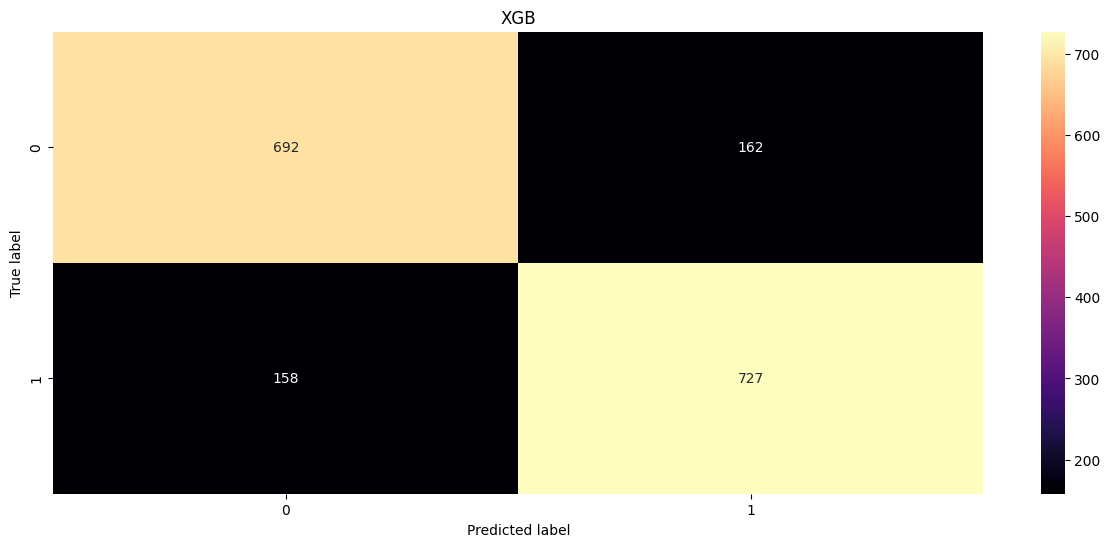

X_train accuracy LogisticReg: 0.7935001438021283

LogisticReg EVALUATION -----------------
Log Loss Pred: 0.4311734256399971
Precision on X_test: 0.7816979051819184
Recall on X_test: 0.8011299435028248
Accuracy Score: 0.7849338700402531
Roc Auc Score: 0.8818355627886052
NULL ACCURACY SCORE ON Y_TEST: 0.5089131684876366



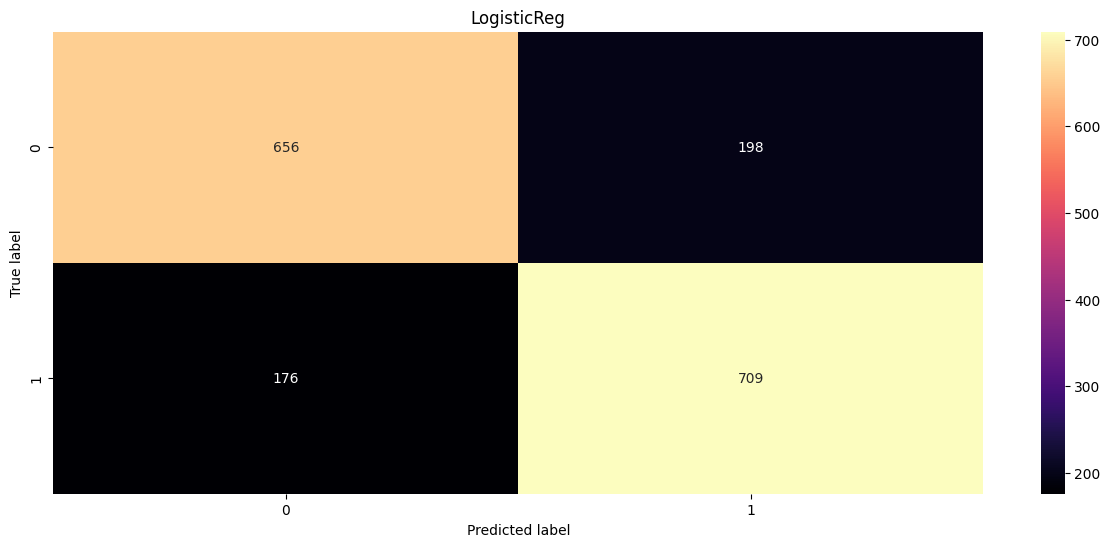

X_train accuracy RandomForest: 0.9926660914581535

RandomForest EVALUATION -----------------
Log Loss Pred: 0.6746408844655035
Precision on X_test: 0.8241082410824109
Recall on X_test: 0.7570621468926554
Accuracy Score: 0.7941345600920069
Roc Auc Score: 0.8632741899204806
NULL ACCURACY SCORE ON Y_TEST: 0.5089131684876366



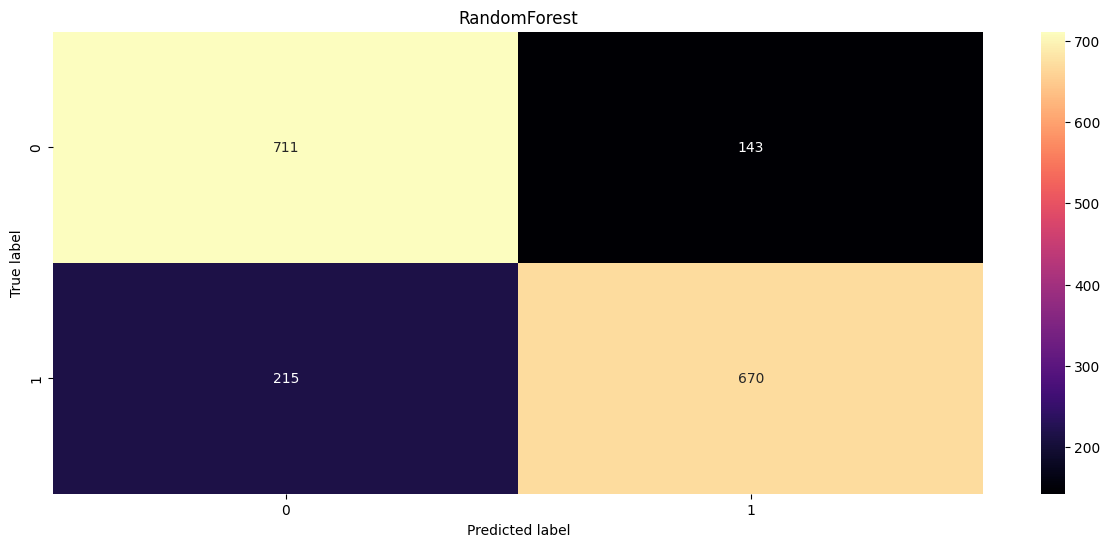

X_train accuracy GradientBoost: 0.8201035375323554

GradientBoost EVALUATION -----------------
Log Loss Pred: 0.395593696558685
Precision on X_test: 0.8
Recall on X_test: 0.8451977401129943
Accuracy Score: 0.8136860264519838
Roc Auc Score: 0.9001032032707499
NULL ACCURACY SCORE ON Y_TEST: 0.5089131684876366



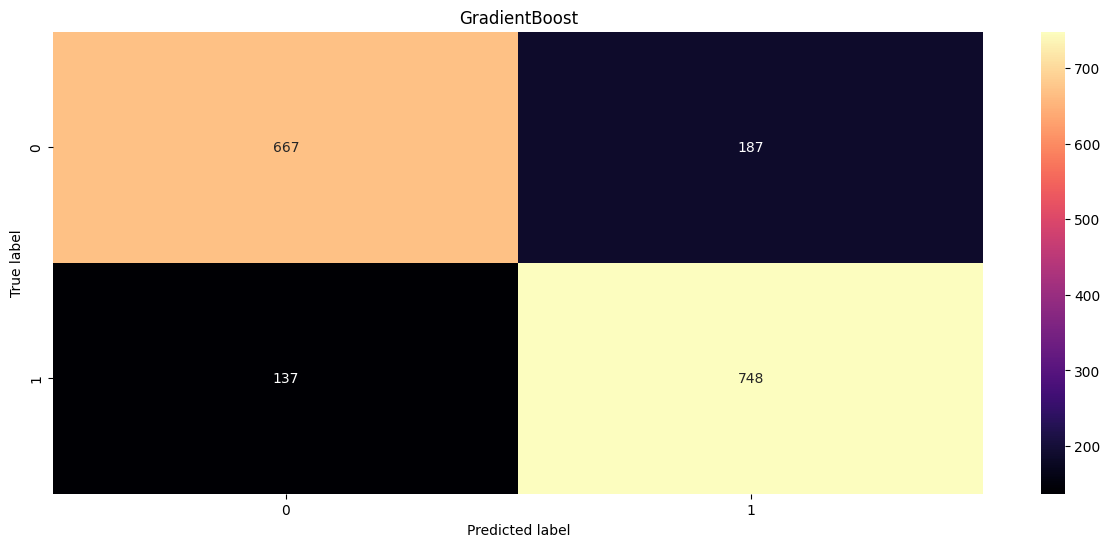

In [158]:
# Get baseline evaluations for each model
for algo, model in models.items():
    model.fit(X_train, y_train)
    
    # X_train/X_test predictions
    X_train_predict = model.predict(X_train)
    X_test_predict = model.predict(X_test)
    
    # X_train metrics
    print(f"X_train accuracy {algo}: {accuracy_score(y_train, X_train_predict)}\n")
    
    # X_test metrics
    metric_testing(model, y_test, X_test_predict, X_test, algo)
    plot_confusion_matrix(y_test, X_test_predict, algo)

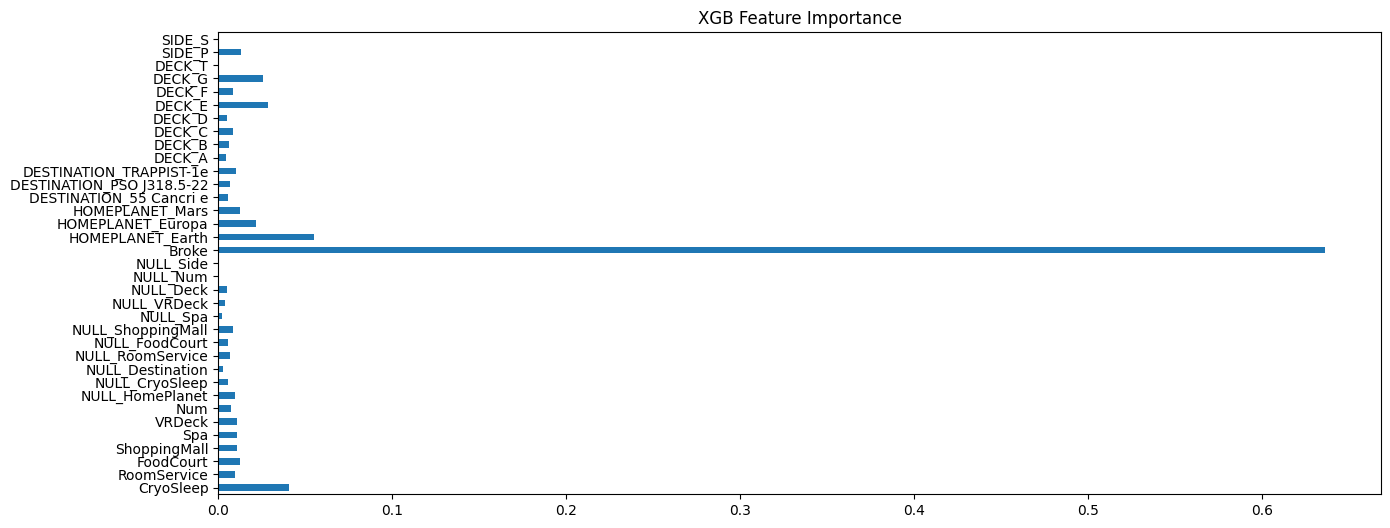

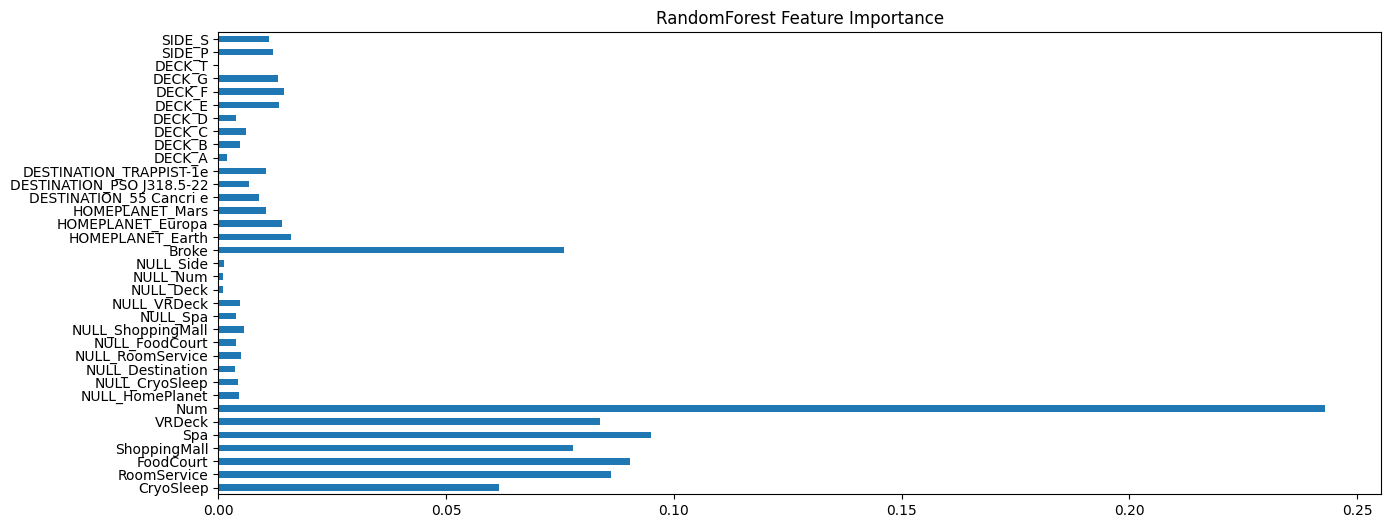

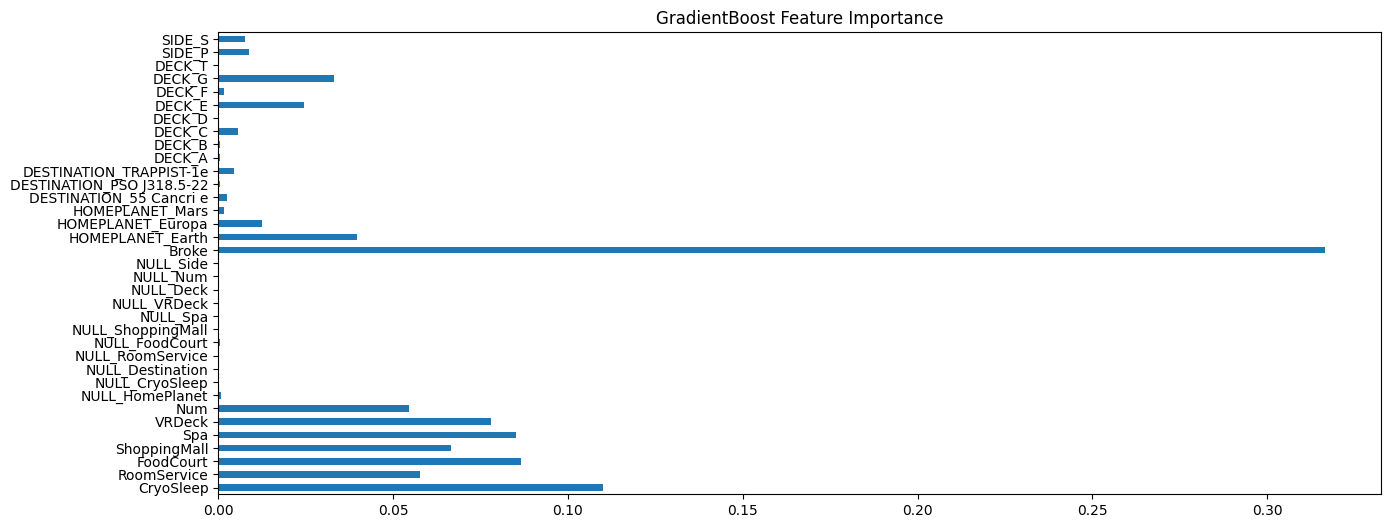

In [160]:
# Plot feature importance
for algo, model in models.items():
    if algo in ['XGB', 'RandomForest', 'GradientBoost']:
        feature_names = X_train.columns
        importances = model.feature_importances_
        plot_feature_importance(importances, feature_names, algo)

#### Parameter Tuning

In [129]:
model_params = {
    # XBG parameters
    'XGB': {
        'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'max_depth': np.arange(1, 16),
        'reg_lambda': np.linspace(0.1, 5.0, 30, endpoint=True),
        'min_child_weight': [1, 3, 5, 7, 9],
        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7]
    },

    # RandomForest parameters
    'RandomForest': {
        'bootstrap': [True, False],
        'criterion': ['entropy', 'gini'],
        'max_depth': range(2, 21),
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': range(1, 11),
        'min_samples_split': range(2, 11),
        'n_estimators': [90, 100, 115, 130, 150]
    },

    # LogisticReg parameters 
    'LogisticReg': {
        'C': np.logspace(-9, 9, 50),
        'penalty': ['l2', 'l1', 'None', 'elasticnet'],
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'max_iter': [10000]
    },
    
    # GradientBooster parameters
    'GradientBoost': {
        'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
        'max_depth': range(5, 9),
        'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
        'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
        'max_features': list(range(1, X_train.shape[1]))
    }
}

In [130]:
import warnings
import os

# Removes warnings in current job (RandomizedSearch CV)
warnings.filterwarnings("ignore")
# Removes warnings in spawned jobs
os.environ['PYTHONWARNINGS']='ignore'

from sklearn.model_selection import RandomizedSearchCV

#### Randomized Search

In [131]:
fit_models = {}
X_full = pd.DataFrame(s.fit_transform(X), columns=X.columns)

# Loop through each model while running RS
for algo, model in models.items():
    print(f"Fitting: {algo}...")
    try:
        random_grid = RandomizedSearchCV(
            model,
            param_distributions=model_params[algo],
            n_iter=300,
            scoring='accuracy',
            n_jobs=-1,
            cv=5,
            verbose=True
        )
        
        # Fit random grid
        random_grid.fit(X_full, y)
    except Exception as e:
        continue
    
    # Run best estimator with X_train/X_test
    best_clf = random_grid.best_estimator_.fit(X_full, y)
    train_predict = best_clf.predict(X_full)
    
    # Add best fitted model to fit_models
    fit_models[algo] = {
        'model': random_grid.best_estimator_,
        'params': random_grid.best_params_,
        'score': random_grid.best_score_,
        'train_score': accuracy_score(y, train_predict)
    }

print(f"\nFitting complete!")

Fitting: XGB...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting: LogisticReg...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting: RandomForest...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting: GradientBoost...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits

Fitting complete!


In [132]:
for algo in fit_models:
    print(f"{algo}:", fit_models[algo]['score'], f"Train:", fit_models[algo]['train_score']) 

XGB: 0.7950117490112103 Train: 0.8118025997929369
LogisticReg: 0.7867253709160524 Train: 0.792016565052341
RandomForest: 0.7998424421532421 Train: 0.8461980904175773
GradientBoost: 0.7835065852033265 Train: 0.7952375474519728


### Final Testing

In [101]:
import pickle

In [102]:
def save_model(model):
    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)

def load_model(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [166]:
# Save model
final_model = fit_models['RandomForest']['model']
save_model(final_model)

In [167]:
test_df = pd.read_csv('test.csv')
ids = test_df['PassengerId']
test_df.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning


In [168]:
# Preprocessing 
preprocessing_train(test_df, test=True)
test_df = onehot_encode(test_df)
test_df = pd.DataFrame(s.transform(test_df), columns=test_df.columns)
test_df.head(3)

,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,NULL_HomePlanet,NULL_CryoSleep,NULL_Destination,...,DECK_A,DECK_B,DECK_C,DECK_D,DECK_E,DECK_F,DECK_G,DECK_T,SIDE_P,SIDE_S
0,1.364685,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.171316,-0.153848,-0.160005,-0.146233,...,-0.174191,-0.313741,-0.306610,-0.241218,-0.334759,-0.724629,1.548235,-0.02399,-0.968181,0.968181
1,-0.732770,-0.333105,-0.275387,-0.283579,2.237598,-0.263003,-1.169342,-0.153848,-0.160005,-0.146233,...,-0.174191,-0.313741,-0.306610,-0.241218,-0.334759,1.380016,-0.645897,-0.02399,-0.968181,0.968181
2,1.364685,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.177238,-0.153848,-0.160005,-0.146233,...,-0.174191,-0.313741,3.261474,-0.241218,-0.334759,-0.724629,-0.645897,-0.02399,-0.968181,0.968181


In [169]:
# Fit model and test data
clf = load_model('model.pkl')
clf.fit(X_full, y)
pred = clf.predict(test_df)

clf

RandomForestClassifier(criterion='entropy', max_depth=13, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=130)

In [170]:
# Create submission dataframe
res = pd.DataFrame({'PassengerId': ids, 'Transported': pred})
res['Transported'].replace(to_replace=[1, 0], value=[True, False], inplace=True)

# Save dataframe
res.to_csv('res.csv', index=False)